<a href="https://colab.research.google.com/github/estmon98/bannksAnalysis/blob/main/Banks_Analysis_Fiserv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Banks Analysis Project**

by: Esteban Montoya

## **Part 1:** Data extraction process explained

**Step 1:** Reading initial data: List of 1813 Banks with their respective FDIC cert and Bank Name as main information needed for the analysis

In [ ]:
# @title
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title
import requests
import pandas as pd
import os

# Load the Excel file
file_path = '/content/drive/MyDrive/Banks data/banks_classify.xlsx'
banks_df = pd.read_excel(file_path)

banks_df

,FDIC Cert.,Bank Name,State,Total Assets,Unnamed: 4,Total Assets (millions)
0,30367,1ST BANK OF SEA ISLE CITY,NJ,313000000,313.0,313.0
1,57298,1ST BANK YUMA,AZ,584400000,584.4,584.4
2,58485,1ST CAPITAL BANK,CA,960400000,960.4,960.4
3,1673,1ST FINANCIAL BANK USA,SD,1116100000,1116.1,1116.1
4,57626,1ST STATE BANK,MI,479400000,479.4,479.4
...,...,...,...,...,...,...
1808,18031,WOODSVILLE GUARANTY SAVINGS BANK,NH,686900000,686.9,686.9
1809,5335,WOODTRUST BANK,WI,630100000,630.1,630.1
1810,57414,WORTHINGTON BANK,TX,510200000,510.2,510.2
1811,28116,YAKIMA FEDERAL SAVINGS AND LOAN ASSOCIATION,WA,1984600000,1984.6,1984.6


**Step 2:** Data extraction with Apple search API to get apple app screenshot for each bank of the list and download all images into a folder with the bank's name.

First limitation: 937/1812 coincidence of url for getting screenshots. (Could be improved)

In [ ]:
# @title
def search_app_store(bank_name):
    base_url = "https://itunes.apple.com/search"
    params = {
        "term": bank_name,
        "entity": "software",
        "country": "us"
    }
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        return None

def download_screenshots(screenshot_urls, download_folder):
    # Ensure the directory exists
    os.makedirs(download_folder, exist_ok=True)

    for idx, url in enumerate(screenshot_urls):
        response = requests.get(url)
        if response.status_code == 200:
            file_path = f"{download_folder}/screenshot_{idx+1}.jpg"
            with open(file_path, "wb") as file:
                file.write(response.content)

In [ ]:
# @title
bank_names = banks_df['Bank Name'].tolist()
for bank_name in bank_names:  # Assume `bank_names` is a list of the names of the banks
    result = search_app_store(bank_name)
    if result and result['resultCount'] > 0:
        # Assuming you're interested in the first result
        app_info = result['results'][0]
        screenshot_urls = app_info.get('screenshotUrls', [])
        download_folder = f"/content/drive/MyDrive/Banks data/screenshots/{bank_name}"  # You might need to create this directory if it doesn't exist
        download_screenshots(screenshot_urls, download_folder)

**Step 3:** Manually selected data to train the model creating two folders:
1. Images of Fiserv products.
2. Images of Non-Fiserv products.

see https://drive.google.com/drive/folders/1HEUAx051rzqndgE_oBJkaY1ZtIr-EzVx?usp=sharing


In [ ]:
# @title
!pip install torch
!pip install torch torchvision -U
!pip install cohere
!pip install tiktoken
!pip install transformers

**Step 4:** Downloaded a pre trained ResNet-18 model (Convolutional neural network) and imported Pytorch library.

https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html

In [ ]:
# @title
import torch
import torch.nn as nn
from torchvision import models

# Load a pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Modify the classifier to fit our binary classification task
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # '2' for Fiserv and Non-Fiserv

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 61.0MB/s]


**Step 5:** Loaded the training dataset and splitted into train and test. Then trained the model.





In [ ]:
# @title
import requests
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split

# Path to your dataset
data_dir = '/content/drive/MyDrive/Banks data/Training Model Data'

# Transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Splitting dataset into train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
# @title
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 10  # You can adjust this

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

print('Finished Training')

Epoch 1, Loss: 0.404158566147089
Epoch 2, Loss: 0.19821274327114224
Epoch 3, Loss: 0.10534081421792507
Epoch 4, Loss: 0.04137509767897427
Epoch 5, Loss: 0.026225418830290437
Epoch 6, Loss: 0.006551314564421773
Epoch 7, Loss: 0.0025264303898438812
Epoch 8, Loss: 0.003769019152969122
Epoch 9, Loss: 0.0027432262839283796
Epoch 10, Loss: 0.0009068122715689241
Finished Training


**Step 6:** After Fine tunning the model got an accuracy of 94.87%

In [ ]:
# @title
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on test images: {100 * correct / total}%')


Accuracy of the model on test images: 94.87179487179488%


**Step 7:** Used the model with all the bank app screenshots to get a classification for each bank with "Uses Fiserv" and "Does Not Use Fiserv"

In [ ]:
model = torch.load('/content/drive/MyDrive/Banks data/entire_model2.pth')
model.eval()

In [ ]:
# @title
import os
import torch
from torchvision import transforms
from PIL import Image
from collections import defaultdict

# Assuming model and device setup as before
# Assuming 'device' is defined as below and used throughout your code
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to predict a single image
def predict_image(image_path, model, device):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(device)  # Move the image tensor to the same device as the model
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
    return predicted.item()

# Directory containing all the bank folders
dataset_path = '/content/drive/MyDrive/Banks data/screenshots'

# Initialize a dictionary to store the final classification of each bank
bank_classification = {}

for bank_name in os.listdir(dataset_path):
    bank_folder = os.path.join(dataset_path, bank_name)
    if os.path.isdir(bank_folder):
        predictions = []  # Store predictions for each image in the bank's folder
        for image_name in os.listdir(bank_folder):
            image_path = os.path.join(bank_folder, image_name)
            if os.path.isfile(image_path):
                prediction = predict_image(image_path, model, device)
                predictions.append(prediction)

        # Determine the bank's classification based on the predictions
        # Example: if more than 50% of the images are classified as using Fiserv
        fiserv_images = predictions.count(1)  # Assuming '1' denotes 'Uses Fiserv'
        total_images = len(predictions)
        if fiserv_images / total_images > 0.5:  # Threshold, adjust as needed
            bank_classification[bank_name] = 'Does Not Use Fiserv'
        else:
            bank_classification[bank_name] = 'Uses Fiserv'

# Print or process the bank_classification dictionary as needed
print(bank_classification)

{'BANK OF LEXINGTON, INC.': 'Does Not Use Fiserv', 'EAST CAMBRIDGE SAVINGS BANK': 'Does Not Use Fiserv', 'FIRST NATIONAL BANK IN PORT LAVACA': 'Does Not Use Fiserv', 'FIRST STATE BANK & TRUST': 'Does Not Use Fiserv', 'GUARDIAN SAVINGS BANK': 'Does Not Use Fiserv', 'BANK OF TRAVELERS REST': 'Uses Fiserv', 'FIRST NATIONAL BANK OF BROOKFIELD': 'Uses Fiserv', 'FIRST STATE BANK SOUTHWEST': 'Does Not Use Fiserv', 'MIDAMERICA NATIONAL BANK': 'Does Not Use Fiserv', 'FIRST BANK KANSAS': 'Does Not Use Fiserv', 'HIGHPOINT COMMUNITY BANK': 'Does Not Use Fiserv', 'PEOPLES STATE BANK': 'Uses Fiserv', 'FREEDOM BANK': 'Does Not Use Fiserv', 'CITIZENS BANK OF KENTUCKY, INC.': 'Does Not Use Fiserv', 'COMMONWEALTH BUSINESS BANK': 'Does Not Use Fiserv', 'FIRST UNITED BANK': 'Does Not Use Fiserv', 'MERCHANTS AND MANUFACTURERS BANK': 'Does Not Use Fiserv', 'KLEBERG BANK, N.A.': 'Does Not Use Fiserv', 'GOLD COAST BANK': 'Does Not Use Fiserv', 'AMALGAMATED BANK OF CHICAGO': 'Uses Fiserv', 'HEARTLAND BANK': 'D

In [ ]:
df = pd.DataFrame(list(bank_classification.items()), columns=['Bank Name', 'Uses Fiserv'])
df

,Bank Name,Uses Fiserv
0,"BANK OF LEXINGTON, INC.",Does Not Uses Fiserv
1,EAST CAMBRIDGE SAVINGS BANK,Does Not Uses Fiserv
2,FIRST NATIONAL BANK IN PORT LAVACA,Does Not Uses Fiserv
3,FIRST STATE BANK & TRUST,Does Not Uses Fiserv
4,GUARDIAN SAVINGS BANK,Does Not Uses Fiserv
...,...,...
932,OAK VALLEY COMMUNITY BANK,Does Not Uses Fiserv
933,FIRST SOUTHERN NATIONAL BANK,Does Not Uses Fiserv
934,BANK OF SPRINGFIELD,Uses Fiserv
935,MNB BANK,Uses Fiserv


**Step 8:** Added the FDIC cert with a merged between the initial data and the bank classification result.

In [ ]:
excel_path = '/content/drive/MyDrive/Banks data/Second_classification.xlsx'

**Step 9:** Used FDIC financial API to get financial information for all banks previusly classified, filtering since 2022-01-01, to get the information by quarter since that date.

see: https://banks.data.fdic.gov/docs/#/



In [ ]:
# @title
import pandas as pd
import requests

# Initialize an empty DataFrame to store the extracted data
columns = ['CERT', 'Report Date', 'Assets', 'Deposits', 'ROA', 'ZIP', 'State Name', 'Risk Date', 'ROE', 'Bank Name','Net income','NET INCOME - RATIO','NETINCQ - Net income - quarterly','NETINCQA - Net income - quarterly','NET INCOME - QUARTERLY RATIO']
extracted_data = pd.DataFrame(columns=columns)

# Loop through the DataFrame to get FDIC certificate numbers
for cert_number in df['FDIC Cert.']:
    response = requests.get(f'https://banks.data.fdic.gov/api/financials?filters=CERT%3A%20{cert_number}%20AND%20REPDTE%3A%5B%222022-01-01%22%20TO%20%222024-12-31%22%5D%20&fields=CERT%2CREPDTE%2CASSET%2CDEP%2CROA%2CZIP%2CSTNAME%2CRISDATE%2CROE%2CNAME%2CCITY%2CNETINC%2CNETINCR%2CNETINCQ%2CNETINCQA%2CNETINCQR&sort_by=REPDTE&sort_order=DESC&limit=500&format=json&download=false&filename=data_file')

    if response.status_code == 200:
        response_data = response.json().get('data', [])
        for item in response_data:
            bank_data = item['data']  # Access the nested 'data' dictionary
            # Extract and organize the data
            row = {
                'CERT': bank_data.get('CERT', ''),
                'Report Date': bank_data.get('REPDTE', ''),
                'Assets': bank_data.get('ASSET', ''),
                'Deposits': bank_data.get('DEP', ''),
                'ROA': bank_data.get('ROA', ''),
                'ZIP':bank_data.get('ZIP', ''),  # Adjust according to actual response if ZIP is available
                'State Name':bank_data.get('STNAME', ''),  # Adjust according to actual response if STNAME is available
                'City':bank_data.get('CITY', ''),  # Adjust according to actual response if RISDATE is available
                'ROE': bank_data.get('ROE', ''),
                'Bank Name': bank_data.get('NAME', ''),
                'Net income': bank_data.get('NETINC', ''),
                'NET INCOME - RATIO': bank_data.get('NETINCR', ''),
                'NETINCQ - Net income - quarterly': bank_data.get('NETINCQ', ''),
                'NETINCQA - Net income - quarterly': bank_data.get('NETINCQA', ''),
                'NET INCOME - QUARTERLY RATIO': bank_data.get('NETINCQR', '')
            }
            extracted_data = extracted_data.append(row, ignore_index=True)
    else:
        print(f"Failed to fetch data for certificate number: {cert_number}. Response status: {response.status_code}")



#print(f"Data extraction complete. Saved to '{output_excel_path}'.")

In [ ]:
extracted_data

,CERT,Report Date,Assets,Deposits,ROA,ZIP,State Name,Risk Date,ROE,Bank Name,Net income,NET INCOME - RATIO,NETINCQ - Net income - quarterly,NETINCQA - Net income - quarterly,NET INCOME - QUARTERLY RATIO,City
0,58164,20230930,362082,309688,1.633919,40503,KENTUCKY,NaN,16.48,BANK OF LEXINGTON INC,4391,1.633552,1674,6696,1.817442,LEXINGTON
1,58164,20230630,374778,324014,1.521896,40503,KENTUCKY,NaN,15.58,BANK OF LEXINGTON INC,2717,1.521896,1480,5920,1.554426,LEXINGTON
2,58164,20230331,386918,345107,1.421051,40503,KENTUCKY,NaN,14.46,BANK OF LEXINGTON INC,1237,1.421051,1237,4948,1.421051,LEXINGTON
3,58164,20221231,309468,267136,0.951393,40503,KENTUCKY,NaN,8.99,BANK OF LEXINGTON INC,2934,0.951393,829,3316,1.070727,LEXINGTON
4,58164,20220930,309924,268086,0.910877,40503,KENTUCKY,NaN,8.65,BANK OF LEXINGTON INC,2105,0.910672,816,3264,1.052297,LEXINGTON
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6554,1616,20230331,322077,291529,0.904356,65248,MISSOURI,NaN,9.64,EXCHANGE BANK OF MISSOURI,710,0.904356,710,2840,0.904356,FAYETTE
6555,1616,20221231,305994,274409,1.010430,65248,MISSOURI,NaN,10.47,EXCHANGE BANK OF MISSOURI,3102,1.010430,835,3340,1.101956,FAYETTE
6556,1616,20220930,300201,271394,0.983759,65248,MISSOURI,NaN,10.19,EXCHANGE BANK OF MISSOURI,2267,0.983538,787,3148,1.044785,FAYETTE
6557,1616,20220630,302411,272488,0.956077,65248,MISSOURI,NaN,9.78,EXCHANGE BANK OF MISSOURI,1480,0.956077,789,3156,1.017569,FAYETTE


**Step 10:** Merged the banks classified by the image with the FDIC financial data.



In [ ]:
merged = extracted_data.merge(df, left_on='CERT', right_on='FDIC Cert.',how='left')
merged

,CERT,Report Date,Assets,Deposits,ROA,ZIP,State Name,Risk Date,ROE,Bank Name_x,Net income,NET INCOME - RATIO,NETINCQ - Net income - quarterly,NETINCQA - Net income - quarterly,NET INCOME - QUARTERLY RATIO,City,Bank Name_y,Uses Fiserv,State,FDIC Cert.
0,58164,20230930,362082,309688,1.633919,40503,KENTUCKY,NaN,16.48,BANK OF LEXINGTON INC,4391,1.633552,1674,6696,1.817442,LEXINGTON,"BANK OF LEXINGTON, INC.",Does Not Uses Fiserv,KY,58164
1,58164,20230630,374778,324014,1.521896,40503,KENTUCKY,NaN,15.58,BANK OF LEXINGTON INC,2717,1.521896,1480,5920,1.554426,LEXINGTON,"BANK OF LEXINGTON, INC.",Does Not Uses Fiserv,KY,58164
2,58164,20230331,386918,345107,1.421051,40503,KENTUCKY,NaN,14.46,BANK OF LEXINGTON INC,1237,1.421051,1237,4948,1.421051,LEXINGTON,"BANK OF LEXINGTON, INC.",Does Not Uses Fiserv,KY,58164
3,58164,20221231,309468,267136,0.951393,40503,KENTUCKY,NaN,8.99,BANK OF LEXINGTON INC,2934,0.951393,829,3316,1.070727,LEXINGTON,"BANK OF LEXINGTON, INC.",Does Not Uses Fiserv,KY,58164
4,58164,20220930,309924,268086,0.910877,40503,KENTUCKY,NaN,8.65,BANK OF LEXINGTON INC,2105,0.910672,816,3264,1.052297,LEXINGTON,"BANK OF LEXINGTON, INC.",Does Not Uses Fiserv,KY,58164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6554,1616,20230331,322077,291529,0.904356,65248,MISSOURI,NaN,9.64,EXCHANGE BANK OF MISSOURI,710,0.904356,710,2840,0.904356,FAYETTE,EXCHANGE BANK OF MISSOURI,Does Not Uses Fiserv,MO,1616
6555,1616,20221231,305994,274409,1.010430,65248,MISSOURI,NaN,10.47,EXCHANGE BANK OF MISSOURI,3102,1.010430,835,3340,1.101956,FAYETTE,EXCHANGE BANK OF MISSOURI,Does Not Uses Fiserv,MO,1616
6556,1616,20220930,300201,271394,0.983759,65248,MISSOURI,NaN,10.19,EXCHANGE BANK OF MISSOURI,2267,0.983538,787,3148,1.044785,FAYETTE,EXCHANGE BANK OF MISSOURI,Does Not Uses Fiserv,MO,1616
6557,1616,20220630,302411,272488,0.956077,65248,MISSOURI,NaN,9.78,EXCHANGE BANK OF MISSOURI,1480,0.956077,789,3156,1.017569,FAYETTE,EXCHANGE BANK OF MISSOURI,Does Not Uses Fiserv,MO,1616


## **Part 2:** Data Analysis

**Step 1:**  Read the data to analyze.

In [ ]:
# @title
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title
import pandas as pd
excel_path = '/content/drive/MyDrive/Banks data/FDIC_data_classification.xlsx'  # Update this with the path to your Excel file
df = pd.read_excel(excel_path, sheet_name='Sheet1')

In [ ]:
df

,CERT,Report Date,Report Date Transformation,Assets,Deposits,ROA,ZIP,State Name,Risk Date,ROE,...,Net income,NET INCOME - RATIO,NETINCQ - Net income - quarterly,NETINCQA - Net income - quarterly,NET INCOME - QUARTERLY RATIO,City,Bank Name_y,Uses Fiserv,State,FDIC Cert.
0,58164,20230930,2023-09-30,362082,309688,1.633919,40503,KENTUCKY,NaN,16.48,...,4391,1.633552,1674,6696,1.817442,LEXINGTON,"BANK OF LEXINGTON, INC.",Does Not Uses Fiserv,KY,58164
1,58164,20230630,2023-06-30,374778,324014,1.521896,40503,KENTUCKY,NaN,15.58,...,2717,1.521896,1480,5920,1.554426,LEXINGTON,"BANK OF LEXINGTON, INC.",Does Not Uses Fiserv,KY,58164
2,58164,20230331,2023-03-31,386918,345107,1.421051,40503,KENTUCKY,NaN,14.46,...,1237,1.421051,1237,4948,1.421051,LEXINGTON,"BANK OF LEXINGTON, INC.",Does Not Uses Fiserv,KY,58164
3,58164,20221231,2022-12-31,309468,267136,0.951393,40503,KENTUCKY,NaN,8.99,...,2934,0.951393,829,3316,1.070727,LEXINGTON,"BANK OF LEXINGTON, INC.",Does Not Uses Fiserv,KY,58164
4,58164,20220930,2022-09-30,309924,268086,0.910877,40503,KENTUCKY,NaN,8.65,...,2105,0.910672,816,3264,1.052297,LEXINGTON,"BANK OF LEXINGTON, INC.",Does Not Uses Fiserv,KY,58164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6554,1616,20230331,2023-03-31,322077,291529,0.904356,65248,MISSOURI,NaN,9.64,...,710,0.904356,710,2840,0.904356,FAYETTE,EXCHANGE BANK OF MISSOURI,Does Not Uses Fiserv,MO,1616
6555,1616,20221231,2022-12-31,305994,274409,1.010430,65248,MISSOURI,NaN,10.47,...,3102,1.010430,835,3340,1.101956,FAYETTE,EXCHANGE BANK OF MISSOURI,Does Not Uses Fiserv,MO,1616
6556,1616,20220930,2022-09-30,300201,271394,0.983759,65248,MISSOURI,NaN,10.19,...,2267,0.983538,787,3148,1.044785,FAYETTE,EXCHANGE BANK OF MISSOURI,Does Not Uses Fiserv,MO,1616
6557,1616,20220630,2022-06-30,302411,272488,0.956077,65248,MISSOURI,NaN,9.78,...,1480,0.956077,789,3156,1.017569,FAYETTE,EXCHANGE BANK OF MISSOURI,Does Not Uses Fiserv,MO,1616


**Step 2:** Get the average and median for the key financial indicators for each group of banks "Does Not Uses Fiserv" and "Uses Fiserv".

In [ ]:
# @title
# Group the data by the 'Uses Fiserv' column and calculate the mean for the specified metrics
grouped_means = df.groupby('Uses Fiserv')[['Assets', 'Deposits', 'ROA', 'ROE', 'Net income']].mean()

grouped_means

,Assets,Deposits,ROA,ROE,Net income
Uses Fiserv,,,,,
Does Not Uses Fiserv,717952.447577,618352.628028,1.105723,12.832342,4482.538012
Uses Fiserv,699003.504800,599023.853190,1.024251,13.052810,4189.663467


**Results:**

Average Assets
*   Banks that do not use Fiserv: US 717,952,448
*   Banks that use Fiserv: US 699,003,505


Average Deposits
*   Banks that do not use Fiserv: US 618,352,628
*   Banks that use Fiserv: US599,023,853

Average Return on Assets (ROA)
*   Banks that do not use Fiserv: 1.11%
*   Banks that use Fiserv: 1.02%

Average Return on Equity (ROE)
*   Banks that do not use Fiserv: 12.83%
*   Banks that use Fiserv: 13.05%

Average Net Income
*   Banks that do not use Fiserv: US 4,482,538
*   Banks that use Fiserv: US 4,189,663



In [ ]:
# @title
# Group the data by the 'Uses Fiserv' column and calculate the mean for the specified metrics
grouped_median = df.groupby('Uses Fiserv')[['Assets', 'Deposits', 'ROA', 'ROE', 'Net income']].median()

grouped_median

,Assets,Deposits,ROA,ROE,Net income
Uses Fiserv,,,,,
Does Not Uses Fiserv,571712.0,496445.5,1.050188,11.795,3149.0
Uses Fiserv,557865.0,479547.0,0.978655,10.700,2891.0


**Results:**

Median Assets
*   Banks that do not use Fiserv: US 571,712,000
*   Banks that use Fiserv: US 557,865,000


Median Deposits
*   Banks that do not use Fiserv: US 496,445,500
*   Banks that use Fiserv: US 479,547,000

Median Return on Assets (ROA)
*   Banks that do not use Fiserv: 1.05%
*   Banks that use Fiserv: 0.98%

Median Return on Equity (ROE)
*   Banks that do not use Fiserv: 11.8%
*   Banks that use Fiserv: 10.7%

Median Net Income
*   Banks that do not use Fiserv: US 3,149,000
*   Banks that use Fiserv: US 2,891,000



**Conclusion:**

We can already see a tendency for the banks that do not use Fiserv to have higher Financial indicators. Now we test to see if they are statiscatically significant.

**Step 3:** t-test to determine if there is a significant difference between the means of the two groups.

In [ ]:
# @title
from scipy.stats import ttest_ind

# Separate the data into two groups: banks that use Fiserv and those that do not
banks_with_fiserv = df[df['Uses Fiserv'] == 'Uses Fiserv']
banks_without_fiserv = df[df['Uses Fiserv'] == 'Does Not Uses Fiserv']

# Prepare a dictionary to hold the t-test results
t_test_results = {}

# List of metrics to test
metrics = ['Assets', 'Deposits', 'ROA', 'ROE', 'Net income']

# Perform t-tests for each metric
for metric in metrics:
    stat, p_value = ttest_ind(banks_with_fiserv[metric], banks_without_fiserv[metric], equal_var=False) # Welch's t-test
    t_test_results[metric] = {'Statistic': stat, 'p-value': p_value}

pd.DataFrame(t_test_results).T

,Statistic,p-value
Assets,-1.699582,0.089303
Deposits,-2.007768,0.044748
ROA,-4.182704,0.000030
ROE,NaN,NaN
Net income,-2.290800,0.022039


**Conclusion:**

The results suggest significant differences in deposits, ROA, and net income between banks that use Fiserv products and those that do not, with banks not using Fiserv generally performing better in these metrics.


**Details Explained**
*   **Assets:** The test statistic is -1.70 with a p-value of 0.089. This suggests that there is not a statistically significant difference in assets between the two groups at the conventional alpha level of 0.05.

*   **Deposits:** The test statistic is -2.01 with a p-value of 0.045. This indicates a statistically significant difference in deposits, with banks not using Fiserv having higher deposits on average.

*   **ROA (Return on Assets):** The test statistic is -4.18 with a very small p-value (0.00003), indicating a statistically significant difference in ROA. Banks not using Fiserv have a higher ROA on average.


*   **ROE (Return on Equity):** The test resulted in a NaN value for both the statistic and p-value, which suggests there may be an issue with the data for this metric, such as it being constant or not varying within one or both groups.

*   **Net Income:** The test statistic is -2.29 with a p-value of 0.022, indicating a statistically significant difference in net income, with banks not using Fiserv having higher net income on average.






**Step 4:** Group data by quarter to create visualizations and get a better view of the metrics over time.

In [ ]:
# @title
# Extract quarter from the 'Report Date Transformation' column for grouping
df['Quarter'] = pd.to_datetime(df['Report Date Transformation']).dt.to_period('Q')

# Group the data by quarter and whether the bank uses Fiserv, then calculate means
quarterly_means = df.groupby(['Quarter', 'Uses Fiserv'])[['Assets', 'Deposits', 'ROA', 'ROE', 'Net income']].mean().reset_index()

# Display the first few rows to verify the structure
quarterly_means.head()

,Quarter,Uses Fiserv,Assets,Deposits,ROA,ROE,Net income
0,2022Q1,Does Not Uses Fiserv,690646.564327,604248.947368,1.002617,10.269693,1719.195906
1,2022Q1,Uses Fiserv,679568.980237,591499.723320,0.937425,9.483478,1615.098814
2,2022Q2,Does Not Uses Fiserv,696670.480994,609651.260234,1.064406,11.447865,3678.216374
3,2022Q2,Uses Fiserv,680732.209486,593262.584980,0.991813,10.940553,3379.071146
4,2022Q3,Does Not Uses Fiserv,706705.102339,617222.774854,1.120800,12.659693,5793.773392


**Average ROA by Quarter**

<Figure size 1200x600 with 0 Axes>

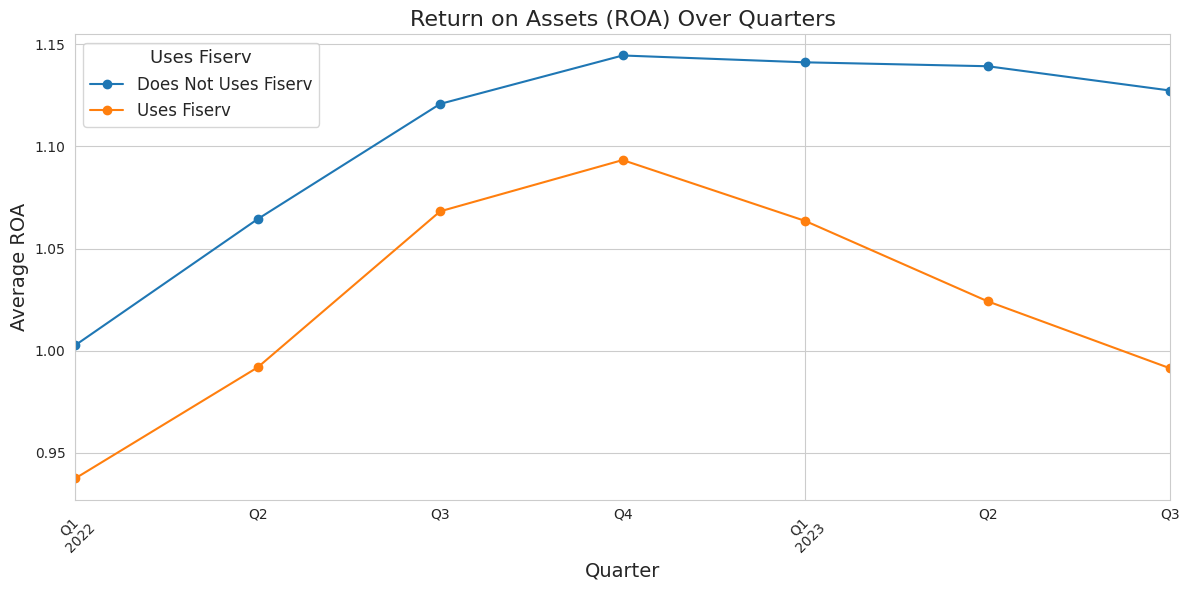

In [ ]:
# @title
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the aesthetic style of the plots
sns.set_style("whitegrid")

# Plotting ROA over quarters for banks that use Fiserv vs those that do not
plt.figure(figsize=(12, 6))

# Filter data for plotting
plot_data = quarterly_means.pivot(index='Quarter', columns='Uses Fiserv', values='ROA')

# Plot
plot_data.plot(kind='line', marker='o', figsize=(12, 6))

plt.title('Return on Assets (ROA) Over Quarters', fontsize=16)
plt.xlabel('Quarter', fontsize=14)
plt.ylabel('Average ROA', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Uses Fiserv', title_fontsize='13', fontsize='12')
plt.tight_layout()

plt.show()

**Average Deposits by Quarter**

<Figure size 1400x800 with 0 Axes>

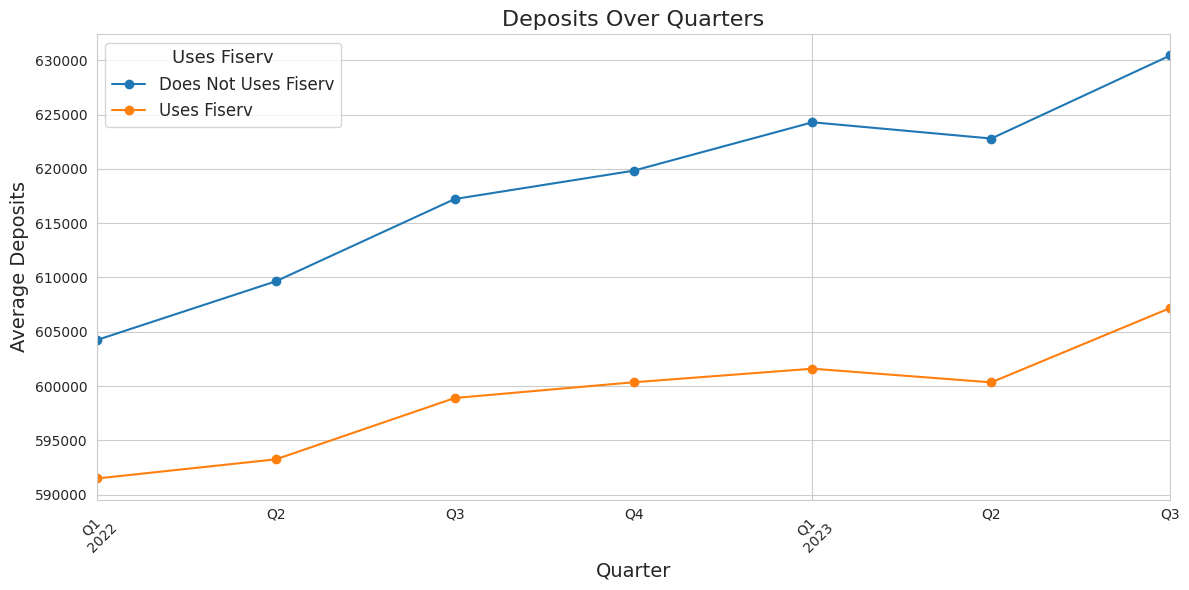

In [ ]:
# @title
# Plotting Deposits over quarters for banks that use Fiserv vs those that do not
plt.figure(figsize=(14, 8))

# Filter data for plotting
plot_data_deposits = quarterly_means.pivot(index='Quarter', columns='Uses Fiserv', values='Deposits')

# Plot
plot_data_deposits.plot(kind='line', marker='o', figsize=(12, 6))

plt.title('Deposits Over Quarters', fontsize=16)
plt.xlabel('Quarter', fontsize=14)
plt.ylabel('Average Deposits', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Uses Fiserv', title_fontsize='13', fontsize='12')
plt.tight_layout()

plt.show()

**Average ROE by Quarter**

<Figure size 1400x800 with 0 Axes>

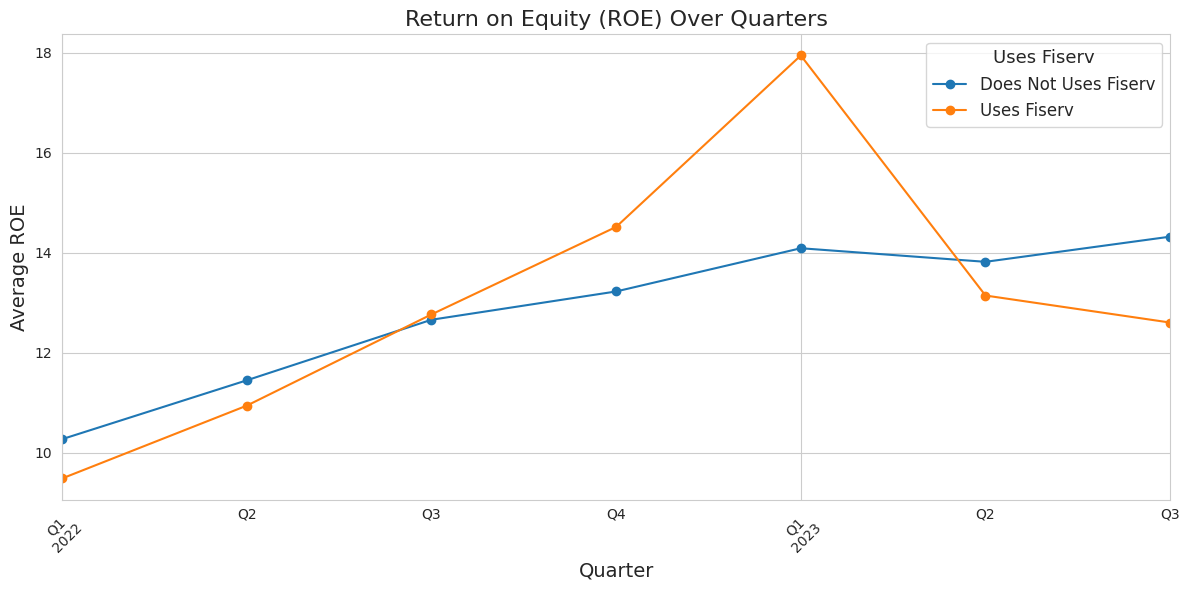

In [ ]:
# @title
# Plotting ROE over quarters for banks that use Fiserv vs those that do not
plt.figure(figsize=(14, 8))

# Filter data for plotting
plot_data_roe = quarterly_means.pivot(index='Quarter', columns='Uses Fiserv', values='ROE')

# Plot
plot_data_roe.plot(kind='line', marker='o', figsize=(12, 6))

plt.title('Return on Equity (ROE) Over Quarters', fontsize=16)
plt.xlabel('Quarter', fontsize=14)
plt.ylabel('Average ROE', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Uses Fiserv', title_fontsize='13', fontsize='12')
plt.tight_layout()

plt.show()

**Average Net Income by Quarter**

<Figure size 1400x800 with 0 Axes>

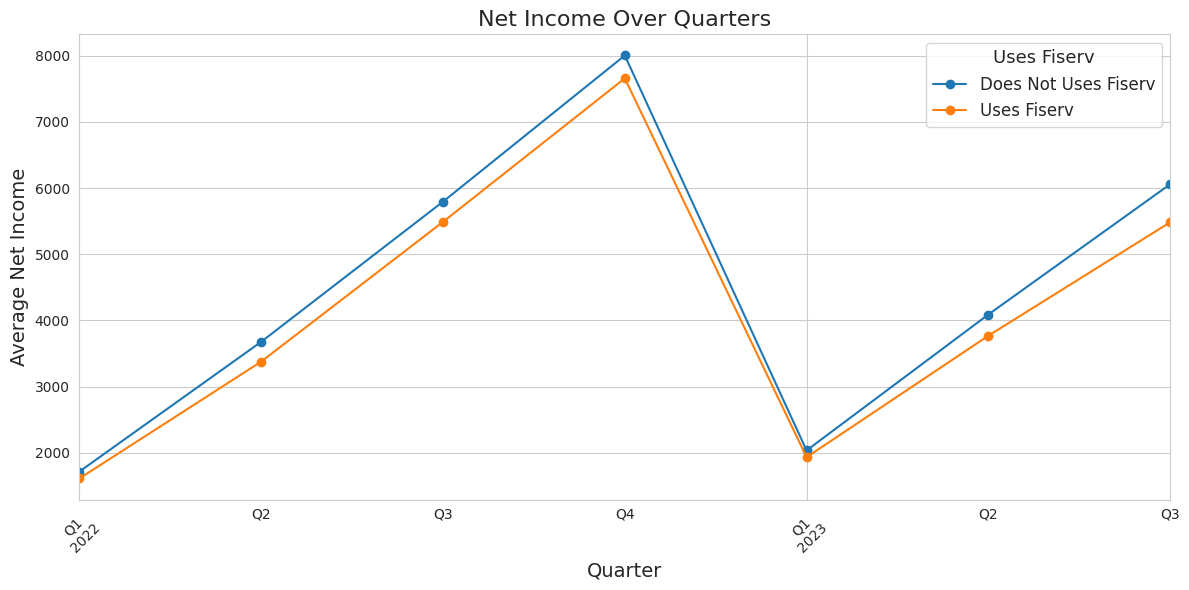

In [ ]:
# @title
# Plotting Net Income over quarters for banks that use Fiserv vs those that do not
plt.figure(figsize=(14, 8))

# Filter data for plotting
plot_data_net_income = quarterly_means.pivot(index='Quarter', columns='Uses Fiserv', values='Net income')

# Plot
plot_data_net_income.plot(kind='line', marker='o', figsize=(12, 6))

plt.title('Net Income Over Quarters', fontsize=16)
plt.xlabel('Quarter', fontsize=14)
plt.ylabel('Average Net Income', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Uses Fiserv', title_fontsize='13', fontsize='12')
plt.tight_layout()

plt.show()


**Conclusion:**

With the information we got we can conclude that there is a correlation between not using Fiserv and having slightly better financial metrics taking into consideration that there are limits to the assumptions made, the extraction process and there are multiple other factors affecting this metrics.

**Return on Equity (ROE) and Net Income Trends:** While there were some quarters where the performance between the two groups diverged significantly, the trends did not consistently favor one group over the other. This could imply that the effectiveness of Fiserv products may be more about enhancing operational efficiency or customer service rather than directly leading to higher profitability or growth.

In [ ]:
# @title
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install xlsxwriter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 4.6 MB/s eta 0:00:00


In [ ]:
# @title
import requests
import pandas as pd
import os
import gspread
#gc = gspread.service_account()
#/content/drive/MyDrive/Banks data/Bank_list_2024_05/data_banks2024_05.csv
#gs = gspread.authorize(credentials)
#gsheet = gs.open('/content/drive/MyDrive/Banks data/Bank_list_2024_05/Community Banks Data.gsheet')
#Sheet_name ="data_banks2024_05"
#wsheet = gsheet.worksheet(Sheet_name)
#df = pd.DataFrame(wsheet.get_all_records())

# Load the Excel file
#file_path = '/content/drive/MyDrive/Banks data/Bank_list_2024_05/Community Banks Data.gsheet'
df = pd.read_csv('/content/drive/MyDrive/Banks data/Bank_list_2024_05/data_banks2024_05.csv')

df

,ACTIVE,ASSET,CBSA,CERT,CITY,COUNTY,DATEUPDT,DEP,DEPDOM,ID,NAME,NETINC,OFFDOM,OFFICES,REPDTE,ROA,ROE,STALP,STNAME,ZIP
0,1,9081050,"Houston-The Woodlands-Sugar Land, TX",23220,The Woodlands,Montgomery,08/31/2022,8088098,8088098,23220,Woodforest National Bank,147808,770,771.0,12/31/2023,1.603883,19.16,TX,Texas,77380
1,1,4302224,"Killeen-Temple, TX",3285,Killeen,Bell,08/31/2022,3490873,3490873,3285,First National Bank Texas,46848,352,350.0,12/31/2023,1.117321,30.67,TX,Texas,76541
2,1,412782,"Little Rock-North Little Rock-Conway, AR",13303,England,Lonoke,08/31/2022,305292,305292,13303,Bank of England,-9950,151,151.0,12/31/2023,-2.254492,-13.41,AR,Arkansas,72046
3,1,9140701,"Marietta, OH",6544,Marietta,Washington,05/11/2023,7185858,7185858,6544,Peoples Bank,124344,142,141.0,12/31/2023,1.504602,13.35,OH,Ohio,45750
4,1,6167505,"Albany-Schenectady-Troy, NY",31945,Glenville,Schenectady,08/31/2022,5350791,5350791,31945,TrustCo Bank,60239,141,140.0,12/31/2023,0.992715,10.01,NY,New York,12302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4424,0,371624,"Muscatine, IA",961,Muscatine,Muscatine,06/21/2022,327615,327615,961,First National Bank of Muscatine,-91,3,NaN,03/31/2022,-0.098380,-0.93,IA,Iowa,52761
4425,0,67832,NaN,9668,Dixon,Webster,05/26/2022,53175,53175,9668,Dixon Bank,72,1,NaN,03/31/2022,0.381578,1.92,KY,Kentucky,42409
4426,0,113677,"Kansas City, MO-KS",9811,Oak Grove,Jackson,01/23/2023,100341,100341,9811,"Commercial Bank of Oak Grove, Mo.",888,1,NaN,12/31/2022,0.778528,7.01,MO,Missouri,64075
4427,0,68646,"Sioux Falls, SD",9947,Lennox,Lincoln,07/20/2023,60056,60056,9947,Valley Exchange Bank,590,2,NaN,06/30/2023,1.613727,14.56,SD,South Dakota,57039


In [ ]:
# @title
import pandas as pd
import requests

# Initialize an empty DataFrame to store the extracted data
columns = ['CERT', 'Report Date', 'Assets', 'Deposits', 'ROA', 'ZIP', 'State Name', 'Risk Date', 'ROE', 'Bank Name','Net income','Non interest income','TOTAL INTEREST INCOME','NETINCQA - Net income - quarterly','NET INCOME - QUARTERLY RATIO']
extracted_data = pd.DataFrame(columns=columns)

# Loop through the DataFrame to get FDIC certificate numbers
for cert_number in df['CERT']:
  response = requests.get(f'https://banks.data.fdic.gov/api/financials?filters=CERT%3A%20{cert_number}%20AND%20REPDTE%3A%5B%222020-01-01%22%20TO%20%222024-12-31%22%5D&sort_by=REPDTE&limit=10000&format=json&download=true&filename=data_file')

  if response.status_code == 200:
      response_data = response.json().get('data', [])
      for item in response_data:
          bank_data = item['data']  # Access the nested 'data' dictionary
          # Extract and organize the data
          row = {
              'CERT': bank_data.get('CERT', ''),
              'Report Date': bank_data.get('REPDTE', ''),
              'Assets': bank_data.get('ASSET', ''),
              'Deposits': bank_data.get('DEP', ''),
              'ROA': bank_data.get('ROA', ''),
              'ZIP':bank_data.get('ZIP', ''),  # Adjust according to actual response if ZIP is available
              'State Name':bank_data.get('STNAME', ''),  # Adjust according to actual response if STNAME is available
              'City':bank_data.get('CITY', ''),  # Adjust according to actual response if RISDATE is available
              'ROE': bank_data.get('ROE', ''),
              'Bank Name': bank_data.get('NAME', ''),
              'Net income': bank_data.get('NETINC', ''),
              'Non interest income': bank_data.get('NONII', ''),
              'TOTAL INTEREST INCOME': bank_data.get('INTINC', ''),
              'NETINCQA - Net income - quarterly': bank_data.get('NETINCQA', ''),
              'NET INCOME - QUARTERLY RATIO': bank_data.get('NETINCQR', '')
          }
          #extracted_data = extracted_data.append(row, ignore_index=True)
          extracted_data = pd.concat([extracted_data, pd.DataFrame([row])], ignore_index=True)
  else:
      print(f"Failed to fetch data for certificate number: {cert_number}. Response status: {response.status_code}")

In [ ]:
extracted_data

,CERT,Report Date,Assets,Deposits,ROA,ZIP,State Name,Risk Date,ROE,Bank Name,Net income,Non interest income,TOTAL INTEREST INCOME,NETINCQA - Net income - quarterly,NET INCOME - QUARTERLY RATIO,City
0,23220,20230331,9339334,8378858,2.375944,77380,TEXAS,NaN,29.47,WOODFOREST NATIONAL BANK,54899,114047,115857,,,THE WOODLANDS
1,23220,20230630,9251928,7968722,2.121479,77380,TEXAS,NaN,25.98,WOODFOREST NATIONAL BANK,98072,234358,238059,,,THE WOODLANDS
2,23220,20230930,9260248,7970827,1.970281,77380,TEXAS,NaN,23.96,WOODFOREST NATIONAL BANK,136681,342178,364768,,,THE WOODLANDS
3,23220,20231231,9081050,8088098,1.603883,77380,TEXAS,NaN,19.16,WOODFOREST NATIONAL BANK,147808,455015,495958,,,THE WOODLANDS
4,3285,20230331,4376823,3646338,1.146347,76541,TEXAS,NaN,33.65,FIRST NATIONAL BANK TEXAS,11924,78874,33049,,,KILLEEN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16748,8810,20230930,892349,788745,1.536125,19973,DELAWARE,NaN,14.87,BANK OF DELMARVA,10498,2910,33862,,,SEAFORD
16749,8813,20230331,568274,498022,-0.525189,21655,MARYLAND,NaN,-7.31,PROVIDENT STATE BANK INC,-754,597,5455,,,PRESTON
16750,9314,20230331,1487347,1229342,1.331564,40223,KENTUCKY,NaN,11.74,LIMESTONE BANK INC,4895,2064,17704,,,LOUISVILLE
16751,9947,20230331,73546,65233,2.064728,57039,SOUTH DAKOTA,NaN,19.51,VALLEY EXCHANGE BANK,389,31,877,,,LENNOX


In [ ]:
extracted_data.to_excel('/content/drive/MyDrive/Banks data/Bank_list_2024_05/Community_banks_income_2020_to_2023.xlsx', engine='xlsxwriter')

In [ ]:
response = requests.get("https://banks.data.fdic.gov/api/financials?filters=CERT%3A23220&fields=CERT%2CNONII%2CINTINC&sort_by=REPDTE&sort_order=DESC&limit=10&offset=0&agg_by=CERT&agg_term_fields=REPDTE&agg_sum_fields=ASSET&agg_limit=1&format=json&download=true&filename=data_file")

In [ ]:
response_data = response.json().get('data', [])

In [ ]:
response_data

[{'data': {'CERT': 23220,
   'count': 160,
   'sum_ASSET': 408094425,
   'count_REPDTE_19840331': 1,
   'count_REPDTE_19840630': 1,
   'count_REPDTE_19840930': 1,
   'count_REPDTE_19841231': 1,
   'count_REPDTE_19850331': 1,
   'count_REPDTE_19850630': 1,
   'count_REPDTE_19850930': 1,
   'count_REPDTE_19851231': 1,
   'count_REPDTE_19860331': 1,
   'count_REPDTE_19860630': 1}}]

In [ ]:
for item in response_data:
        bank_data = item['data']
        print(bank_data)

{'CERT': 23220, 'count': 160, 'sum_ASSET': 408094425, 'count_REPDTE_19840331': 1, 'count_REPDTE_19840630': 1, 'count_REPDTE_19840930': 1, 'count_REPDTE_19841231': 1, 'count_REPDTE_19850331': 1, 'count_REPDTE_19850630': 1, 'count_REPDTE_19850930': 1, 'count_REPDTE_19851231': 1, 'count_REPDTE_19860331': 1, 'count_REPDTE_19860630': 1}
